In [1]:
import utils_v2 as utils
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
# SEED = 12345
# tf.compat.v1.random.set_random_seed(SEED)
# tf.random.set_seed(SEED)
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [2]:
data = "B06" # [B05, B06, B07, B18]

In [3]:
feature = "C + VIT" # [C + V, C + VIT]

In [4]:
model = "hybrid" # [LSTM, hybrid]

In [5]:
dataDict = {
    "B05" : 0,
    "B06" : 1,
    "B07" : 2,
    "B18" : 3,
}

In [6]:
featureDict = {
    "C + V" : 0,
    "C + VIT" : 1
}

In [7]:
modelDict = {
    "LSTM" : 0,
    "hybrid": 1
}

# Ekstraksi Data

In [8]:
dataPath = "data/NASA/"

In [9]:
x_test, y_test = utils.getData(dataPath)

In [10]:
if featureDict[feature] == 0:
    print("Feature: Single-channel ",feature)
    if modelDict[model] == 0 :
        print("Model: ", model)
        testX, testY, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        SC_LSTM_model = tf.keras.models.load_model("model_from_colab/SC/LSTM/SC_LSTM_5_B18_k2/saved_model_and_weight/")
        SC_LSTM_pred = SC_LSTM_model.predict(testX)
        inv_pred = SS.inverse_transform(SC_LSTM_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()
        
    elif modelDict[model] == 1:
        print("Model: ", model)
        testX_SC_h_LSTM, testY_SC_h_LSTM, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], c = True)
        testX_SC_h_CNN, testY_SC_h_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        SC_hybrid_model = tf.keras.models.load_model("model_from_colab/SC/hybrid/SC-CNN-LSTM_5_B07_k2/saved_model_and_weight/")
        SC_hybrid_pred = SC_hybrid_model.predict([testX_SC_h_LSTM, testX_SC_h_CNN])
        inv_pred = SS.inverse_transform(SC_hybrid_pred)  
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()
        
elif featureDict[feature] == 1:
    print("Feature: Multi-channel ", feature)
    if modelDict[model] == 0:
        print("Model: ", model)
        testX, testY, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        MC_LSTM_model = tf.keras.models.load_model("model_from_colab/MC/LSTM/MC_LSTM_5_B06_k2/saved_model_and_weight/")
        MC_LSTM_pred = MC_LSTM_model.predict(testX)
        inv_pred = SS.inverse_transform(MC_LSTM_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()
        
    elif modelDict[model] == 1:
        print("Model: ", model)
        testX_MC_h_LSTM, testY_MC_h_LSTM, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], c = True)
        testX_MC_h_V_CNN, testY_MC_h_V_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], v = True)
        testX_MC_h_I_CNN, testY_MC_h_I_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], II = True)
        testX_MC_h_T_CNN, testY_MC_h_T_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], t = True)
        MC_hybrid_model = tf.keras.models.load_model("model_from_colab/MC/hybrid/SCNN+LSTM_5_B07_k3/saved_model_and_weight/")
        MC_hybrid_pred = MC_hybrid_model.predict([testX_MC_h_LSTM, testX_MC_h_V_CNN, testX_MC_h_I_CNN, testX_MC_h_T_CNN])
        inv_pred = SS.inverse_transform(MC_hybrid_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()

Feature: Multi-channel  C + VIT
Model:  hybrid


In [11]:
threshold = np.zeros((len(inv_pred)))
threshold.fill(1.4)
t = threshold

In [12]:
if dataDict[data] == 0:
    intersection = np.argwhere(np.isclose(t, pred_flat, rtol=0.001, atol=0.001)).flatten()
elif dataDict[data] == 3 and modelDict[model] == 1 and featureDict[feature] == 0:
    intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
    intersection = intersection + 1
elif dataDict[data] == 3:
    intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
else:
    intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()

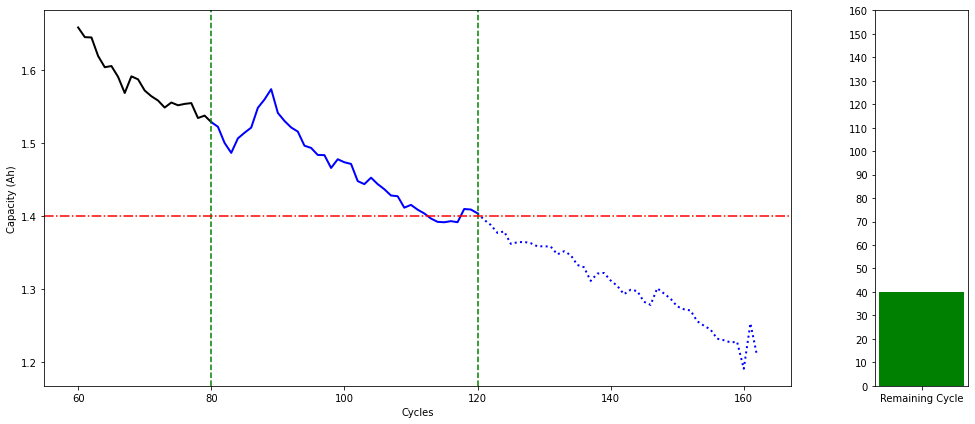

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [8, 1]})
try: 
    ax1.plot(X[60:81], pred_flat[60:81], linewidth=2, color='k')
    ax1.plot(X[80:intersection[-1]+1], pred_flat[80:intersection[-1]+1], linewidth=2, color='b')
    ax1.plot(X[intersection[-1]:], pred_flat[intersection[-1]:], linewidth=2, color='b', ls=':')

    ax1.axvline(x=80, color='g', ls='--', label="Starting Point")
    ax1.axvline(intersection[-1], color='g', ls='--')

    ax1.axhline(y=1.4, color='r', ls='-.', label="Failure Threshold")

    ax1.set_ylabel("Capacity (Ah)")
    ax1.set_xlabel("Cycles")

    # ax2 = fig.add_subplot(122)
    ax2.bar(['Remaining Cycle'], [intersection[-1]-80], color = 'g')
    ax2.set_yticks(np.arange(0, max(X), 10));
    
except Exception as e:
    ax1.plot(X, pred_flat, linewidth=2, color='k')
    ax1.set_yticks(np.arange(1.4, max(pred_flat), 0.15));
    ax2.set_yticks(np.arange(0, max(X), 10));
    ax2.set_xticks([1]);
    ax1.set_ylabel("Capacity (Ah)")
    ax1.set_xlabel("Cycles")
    ax2.set_xlabel("Remaining cycles")

fig.tight_layout()
plt.subplots_adjust(right=0.9,
                    wspace=0.2)

In [14]:
text = f"{intersection[-1]-80} cycles remaining"

In [15]:
print(text)

40 cycles remaining
